In [102]:
import cv2 
import numpy as np
import matplotlib.pylab as plt
import math 

def showC(img):
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(rgb,cmap="gray")
    
def show(img):
    plt.imshow(img,cmap="gray")

# **SelectShapeStd, Gray Selection, Smoothing Image**
Link Document: https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html

1. Image Filtering (LPF, HPF)
2. Image Bluring

# **SelectShapeStd**

* select shape width max area, max with, max height

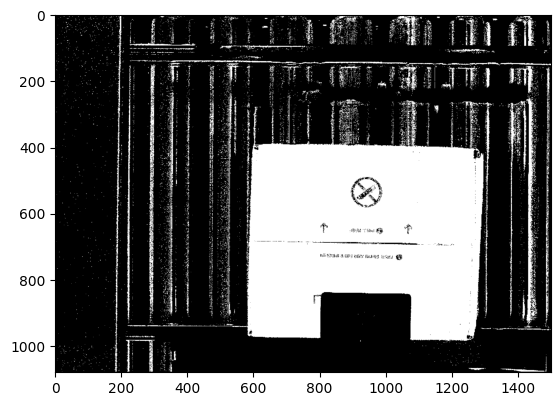

In [103]:
img = cv2.imread("images/box3kg.bmp")
showC(img)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)

mask  = cv2.inRange(hsv, np.array([12, 47, 77]) , np.array([61, 255, 255]))
show(mask)


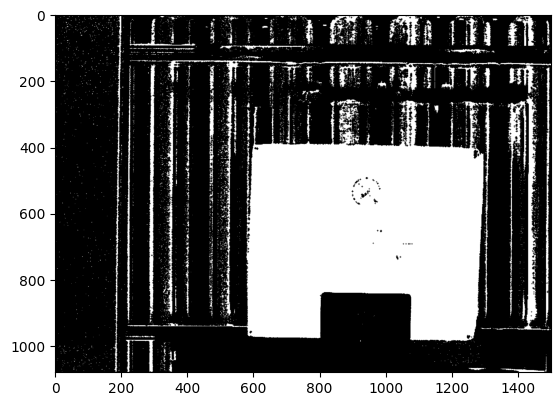

In [104]:
def ClosingCircle(image, radius):
    mask = cv2.getStructuringElement(cv2.MORPH_CROSS, ksize = (2*radius + 1, 2*radius +1))
    dilation = cv2.dilate(image, mask , iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    closing = cv2.erode(dilation, mask , iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    return closing

closing = ClosingCircle(mask,2)
show(closing)

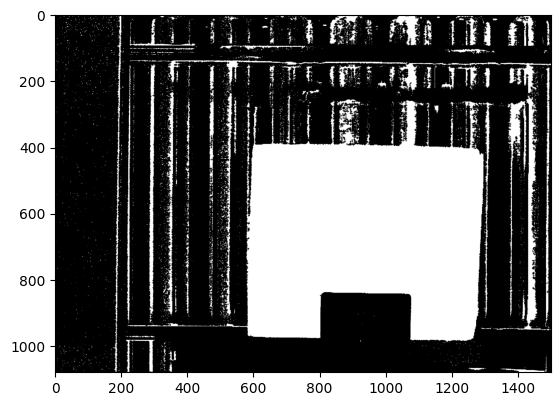

In [105]:
def FillUp(region):
    region =region.astype(np.uint8)
    # add padding
    im_floodfill = cv2.copyMakeBorder(region, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0)

    # Create mask (ROI)
    h, w = im_floodfill.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    cv2.floodFill(im_floodfill, mask, (0,0), 255, flags = 4)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_floodfill_inv = im_floodfill_inv[1:(1 + region.shape[0]), 1:(1 + region.shape[1])]

    RegionFillUp = region | im_floodfill_inv
    return RegionFillUp

fillUp = FillUp(closing)
show(fillUp)

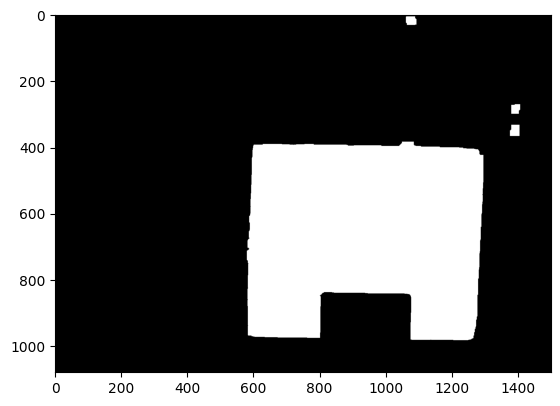

In [106]:
def OpeningRectangle(image, width, height):
    mask = cv2.getStructuringElement(cv2.MORPH_RECT, ksize = (width, height))
    erosion = cv2.erode(image, mask, iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    opening = cv2.dilate(erosion, mask, iterations = 1, borderType = cv2.BORDER_DEFAULT, borderValue = 0)
    return opening


opening_x = OpeningRectangle(fillUp, 27, 1)
opening_y = OpeningRectangle(opening_x, 1, 17)
show(opening_y)

In [107]:
def SelectShapeStd(region ,mode = "area"):
    
    number_object,labels , stats, center = cv2.connectedComponentsWithStats(region, 4, cv2.CV_32S)
    
    print(stats)
    list_width  = list(stats[1:, 2])
    list_height = list(stats[1:, 3])
    list_area   = list(stats[1:, 4])
    
    max_value_area = max(list_area) 
    index_max_area = list_area.index(max_value_area)  +1 
    
    max_value_width= max(list_width) 
    index_max_width = list_width.index(max_value_width) +1 
    
    max_value_height = max(list_height)
    index_max_height = list_height.index(max_value_height)  +1 
    
    select_obj = np.zeros((region.shape), dtype=np.uint8)
    
    print(index_max_area,index_max_width,index_max_height)
    if mode == "area":
        select_obj[labels ==index_max_area] = 255
        select_obj[labels !=index_max_area] = 0
        
    elif mode == "width":
        select_obj[labels ==index_max_width] = 255
        select_obj[labels !=index_max_width] = 0
        
    elif mode == "height":
        select_obj[labels ==index_max_height] = 255
        select_obj[labels !=index_max_height] = 0
        
        
    return select_obj

[[      0       0    1500    1080 1249260]
 [   1059       7      32      26     781]
 [   1377     272      27      29     718]
 [   1373     334      29      34     922]
 [    579     385     714     599  368319]]
4 4 4


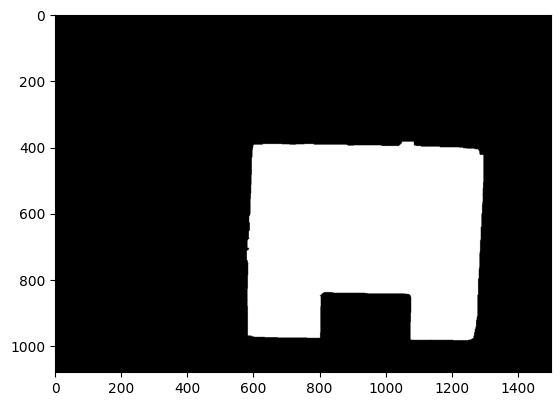

In [108]:
biggest_region = SelectShapeStd(opening_y, mode="width")
show(biggest_region)

## **Gray Selection**
1. min, max gray selection,
2. variance, standard deviation
3. entropy 

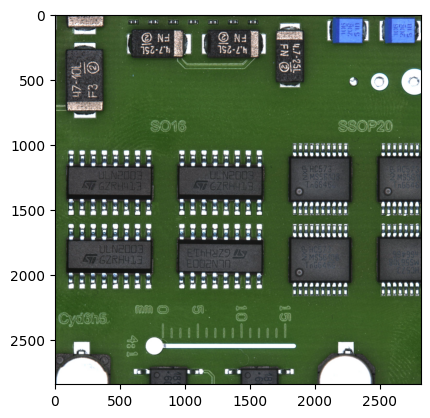

In [109]:
img = cv2.imread("images/BOARD2.jpg")
show(img)

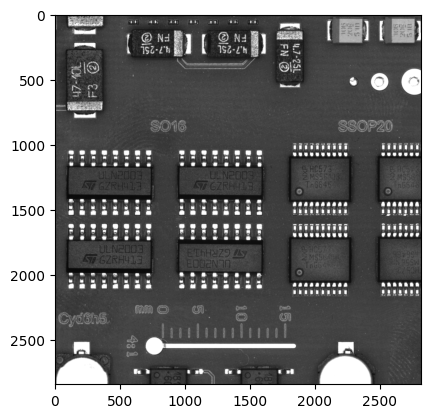

In [110]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, threshold =cv2.threshold(gray, 40,255, cv2.THRESH_BINARY_INV)
show(gray)

In [111]:
# ADD 
threshold[: , threshold.shape[1]-1] = 255

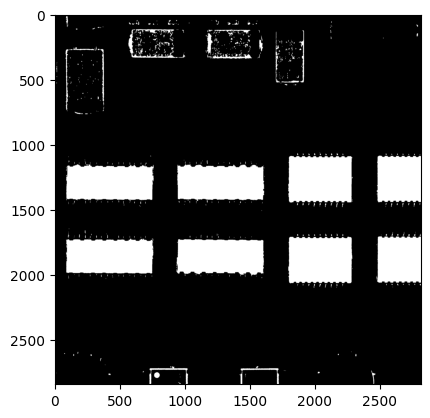

In [112]:
fillUp = FillUp(threshold)
fillUp = OpeningRectangle(fillUp, 2,5)
show(fillUp)

In [113]:
def Select_Shape(threshold,min_value, max_value, feature = "width"): 
    
    number_object,labels , stats, center = cv2.connectedComponentsWithStats(threshold, 4, cv2.CV_32S)
    
    list_width = list(stats[1: ,2])
    list_height = list(stats[1: ,3])
    list_area = list(stats[1: ,4])
    
    #
    result = np.zeros((threshold.shape[0], threshold.shape[1]),dtype =np.uint8)
    
    # 
    list_output_width = []
    list_output_height = []
    list_output_area =[]
    #
    list_region  = []
    # ----------------------------------------------------- WIDTH
    if feature == "width":
        for idx in range(1,number_object):
            width  = list_width[idx -1]
            height = list_height[idx -1]
            area   = list_area[idx -1]
            
            if width > min_value  and width < max_value:
                select_object = np.zeros( (threshold.shape[0], threshold.shape[1]),dtype =np.uint8)
                
                select_object[labels == idx] = 255
                select_object[labels != idx] = 0
                
                list_region.append(select_object)
                result = cv2.bitwise_or(result,select_object)
                list_output_width.append(width)
                
                list_output_height.append(height)
                list_output_area.append(area)
                
        return result,list_region,(list_output_width,list_output_height , list_output_area)
    
    # ----------------------------------------------------- HEIGHT 
    elif feature == "height":
        for idx in range(1,number_object):
            width  = list_width[idx -1]
            height = list_height[idx -1]
            area   = list_area[idx -1]
            
            if height > min_value  and height < max_value:
                select_object = np.zeros( (threshold.shape[0], threshold.shape[1]),dtype =np.uint8)
                
                select_object[labels == idx] = 255
                select_object[labels != idx] = 0
                
                list_region.append(select_object)
                
                result = cv2.bitwise_or(result,select_object)
                list_output_width.append(width)
                
                list_output_height.append(height)
                list_output_area.append(area)
                
        return result,list_region,(list_output_width,list_output_height , list_output_area     )         
    
    
    # ----------------------------------------------------- AREA
    elif feature == "area":
        for idx in range(1,number_object):
            width  = list_width[idx -1]
            height = list_height[idx -1]
            area   = list_area[idx -1]
            
            if area > min_value  and area < max_value:
                
                select_object = np.zeros( (threshold.shape[0], threshold.shape[1]),dtype =np.uint8)
                
                select_object[labels == idx] = 255
                select_object[labels != idx] = 0
                
                list_region.append(select_object)
                
                result = cv2.bitwise_or(result,select_object)
                list_output_width.append(width)
                
                list_output_height.append(height)
                list_output_area.append(area)
                
        return result,list_region,(list_output_width,list_output_height , list_output_area)
    
    # ----------------------------------------------------- Circularity 
    # ----------------------------------------------------- Squaredness    

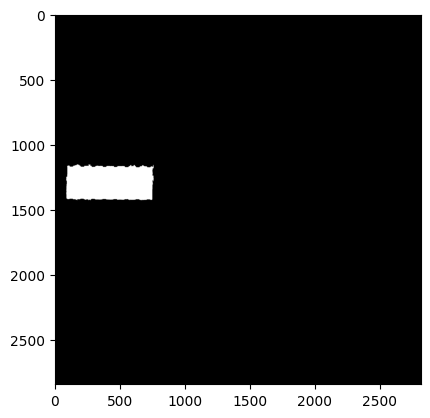

In [114]:
region, list_region, data = Select_Shape(fillUp,100000, 500000, feature ="area")
len(list_region)
show(list_region[3])

In [115]:
min_gray_value, max_gray_value, _, _  = cv2.minMaxLoc(gray,mask = list_region[3])
min_gray_value, max_gray_value


(12.0, 97.0)

## Variance, Standard Deviation

In [116]:
mean , std = cv2.meanStdDev(gray,mask = list_region[3])
print(mean, std)

for region in list_region:
    mean , std = cv2.meanStdDev(gray,mask = region)
    print(mean , std)

[[55.17987322]] [[18.75639977]]
[[69.05399346]] [[19.55189255]]
[[64.85097693]] [[19.08421469]]
[[57.17959114]] [[18.31047586]]
[[55.17987322]] [[18.75639977]]
[[65.93854231]] [[17.29979433]]
[[66.79466343]] [[19.64464606]]
[[58.15894664]] [[21.10233424]]
[[61.45381919]] [[20.57237764]]


### Entropy 

In [117]:
import math 
def calc_entropy (image, mask = None):
    min_gray, max_gray , _, _ = cv2.minMaxLoc(image, mask  = mask)
    
    hist = cv2.calcHist([gray],[0], None, [256], [min_gray, max_gray])


    entropy = 0.0 
    
    hist = (hist / np.sum(hist))
    for i in range(256):
        num_pixel = hist[i][0]
        if num_pixel ==0:
            log = 0
            
        else:
            log = math.log(num_pixel, math.e)
            
        entropy += - num_pixel*log
    return entropy

In [118]:
entropy = calc_entropy(gray, mask = list_region[3])
entropy


3.7657375539165057

In [119]:
for region in list_region:
    entropy = calc_entropy(gray, mask = region)
    print(entropy)
    

4.01705529828523
4.0046858159786165
3.820447120803085
3.7657375539165057
3.819551857519929
4.0411899781933815
3.8325260038065094
3.842722555279495


In [120]:
def SelectGray(gray, list_mask, min_value, max_value ,feature = "gray_value"):
    
    select_gray_region = np.zeros((gray.shape), dtype = np.uint8)
    
    for region in list_mask :
        
        if feature == "gray_value":
            min_gray, max_gray = cv2.minMaxLoc(gray, mask = region)
            if min_gray > min_value and max_gray <  max_value:                 
                select_gray_region = cv2.bitwise_or(select_gray_region,region)
                
        elif feature == "mean":   
            mean , std = cv2.meanStdDev(gray,mask = region)
            if mean[0] > min_value and mean[0] < max_value:
                select_gray_region = cv2.bitwise_or(select_gray_region,region)
                
        elif feature == "std":
            mean , std = cv2.meanStdDev(gray,mask = region)
            if std[0] > min_value and std[0] < max_value:
                select_gray_region = cv2.bitwise_or(select_gray_region,region)

        elif feature == "entropy":
            entropy = calc_entropy(gray, mask = region)
            if entropy > min_value and entropy < max_value:
                select_gray_region = cv2.bitwise_or(select_gray_region,region)
        
    return select_gray_region, cv2.bitwise_and(gray, select_gray_region)

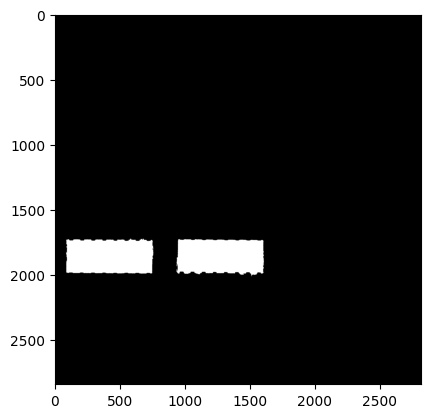

In [121]:
list_gray_region, list_image_gray = SelectGray(gray, list_region ,20.0 , 22.0 , feature= "std")
show(list_gray_region)

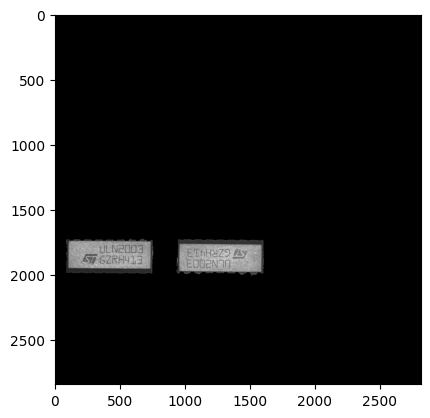

In [122]:
show(list_image_gray)

# **Image Filtering**
1. 2D Convolution 

In [123]:
gray = cv2.imread("images/SG1.png",0)

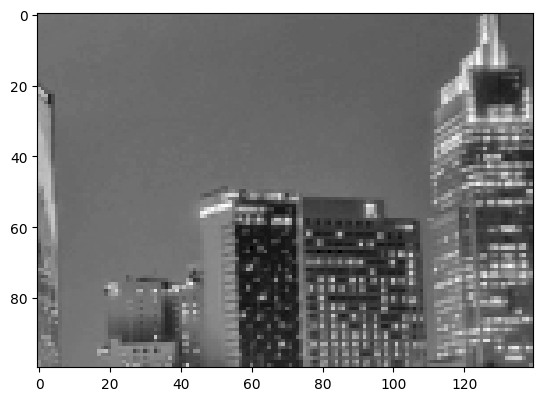

In [124]:
crop = gray[100:200 , 300:440]
show(crop)

In [125]:
kernel_size = 3

filtered  = np.zeros((gray.shape[0] ,gray.shape[1]), dtype = np.uint8)

gray_padding = np.zeros((gray.shape[0]+2 ,gray.shape[1] +2), dtype = np.uint8)
gray_padding[1:gray.shape[0]+1 , 1:gray.shape[1] +1] = gray

for y in range(gray.shape[0] - kernel_size):
    for x in range(gray.shape[1] - kernel_size):
    
        crop = gray_padding[y: y+kernel_size, x: x+ kernel_size ]
        mean = np.mean(crop)
                
        filtered[y, x] = mean

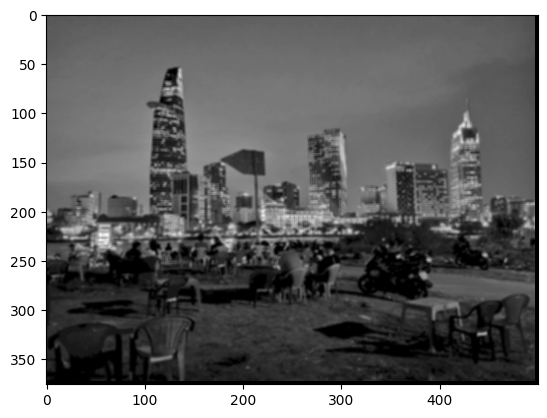

In [126]:
show(filtered)

# **Image Bluring**
1. Averaging
2. Median Bluring
3. Gaussian Bluring


### Averaging -Code

In [127]:
kernel_size = 3

filtered  = np.zeros((gray.shape[0] ,gray.shape[1]), dtype = np.uint8)

gray_padding = np.zeros((gray.shape[0]+2 ,gray.shape[1] +2), dtype = np.uint8)
gray_padding[1:gray.shape[0]+1 , 1:gray.shape[1] +1] = gray

for y in range(gray.shape[0] - kernel_size):
    for x in range(gray.shape[1] - kernel_size):
    
        crop = gray_padding[y: y+kernel_size, x: x+ kernel_size ]
        mean = np.mean(crop)
                
        filtered[y, x] = mean

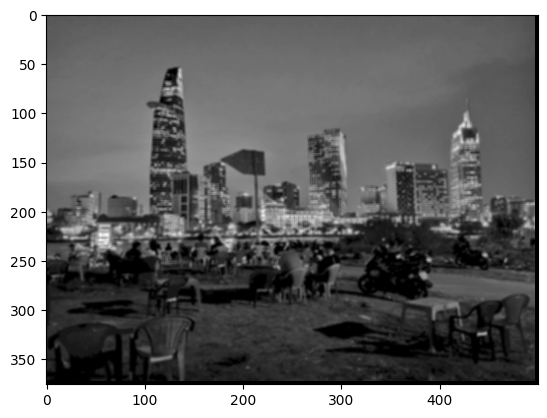

In [128]:
show(filtered)

### Averaging-OpenCV

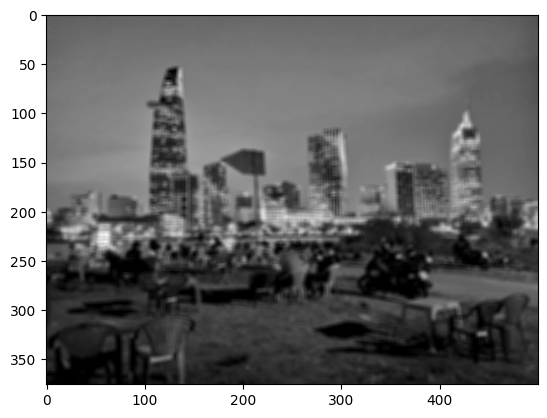

In [129]:
filtered = cv2.blur(gray,(5,5))
show(filtered)

### Median Bluring - Code

In [130]:
kernel_size = 3 

filtered  = np.zeros((gray.shape[0] ,gray.shape[1]), dtype = np.uint8)

gray_padding = np.zeros((gray.shape[0]+2 ,gray.shape[1] +2), dtype = np.uint8)
gray_padding[1:gray.shape[0]+1 , 1:gray.shape[1] +1] = gray


for y in range(gray.shape[0] - kernel_size):
    for x in range(gray.shape[1] - kernel_size):
    
        crop = gray_padding[y: y+kernel_size, x: x+ kernel_size ]
        mean = np.median(crop)
            
        filtered[y, x] = mean

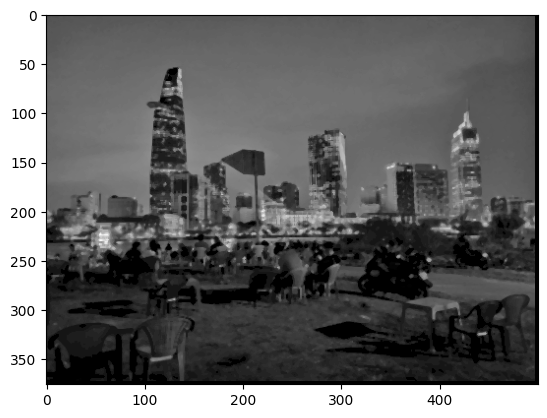

In [131]:
show(filtered)

### Median - Opencv

### Gaussian - Code

$$ G(x, y) = \frac{1}{2\pi \sigma_X \sigma_Y} \exp\left(-\frac{x^2}{2\sigma_X^2} - \frac{y^2}{2\sigma_Y^2}\right) $$

In [132]:
"""
X, y đại điện cho tạo độ của gaussian kernel 
"""

def gaussian(x, y, mean_x, mean_y, sigma_x, sigma_y):
    coefficient = 1 / (2 * np.pi * sigma_x * sigma_y)
    exponent = -((x ** 2) / (2 * sigma_x ** 2) + (y ** 2) / (2 * sigma_y ** 2))
    result = coefficient * np.exp(exponent)

    return result

x = np.linspace(-1, 1, 5)
y = np.linspace(-1, 1, 5)

print(x)
print(y)
print("-----------------------")
x, y = np.meshgrid(x, y)

print(f'x: {x}')
print("-----------------------")
print(f'y: {y}')

[-1.  -0.5  0.   0.5  1. ]
[-1.  -0.5  0.   0.5  1. ]
-----------------------
x: [[-1.  -0.5  0.   0.5  1. ]
 [-1.  -0.5  0.   0.5  1. ]
 [-1.  -0.5  0.   0.5  1. ]
 [-1.  -0.5  0.   0.5  1. ]
 [-1.  -0.5  0.   0.5  1. ]]
-----------------------
y: [[-1.  -1.  -1.  -1.  -1. ]
 [-0.5 -0.5 -0.5 -0.5 -0.5]
 [ 0.   0.   0.   0.   0. ]
 [ 0.5  0.5  0.5  0.5  0.5]
 [ 1.   1.   1.   1.   1. ]]


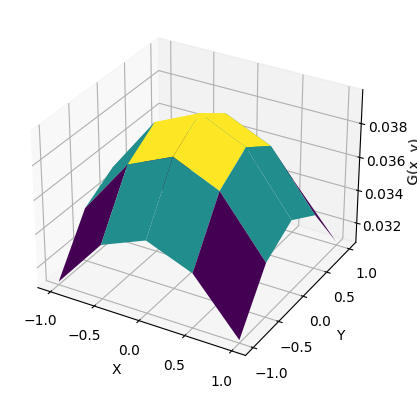

array([[0.0309875 , 0.03403311, 0.03511344, 0.03403311, 0.0309875 ],
       [0.03403311, 0.03737806, 0.03856457, 0.03737806, 0.03403311],
       [0.03511344, 0.03856457, 0.03978874, 0.03856457, 0.03511344],
       [0.03403311, 0.03737806, 0.03856457, 0.03737806, 0.03403311],
       [0.0309875 , 0.03403311, 0.03511344, 0.03403311, 0.0309875 ]])

In [133]:
"""
z: đại diện cho giá trị của gaussian kernel 
"""
mean_x =  0
mean_y =  0

sigma_x = 2
sigma_y = 2


z = gaussian(x, y, mean_x, mean_y, sigma_x, sigma_y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y, z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('G(x, y)')
plt.show()

kernel_gaussian = z
kernel_gaussian

In [137]:
kernel_size

gaussianed   = np.zeros((gray.shape[0] ,gray.shape[1]), dtype = np.uint8)

gray_padding = np.zeros((gray.shape[0]+2 ,gray.shape[1] +2), dtype = np.uint8)
gray_padding[1:gray.shape[0]+1 , 1:gray.shape[1] +1] = gray


for y in range(gray.shape[0]):
    for x in range(gray.shape[1]):
        
        s = np.array([0.0])
        for i in range(kernel_size):
            for j in range(kernel_size):
                s +=  np.float64(gray_padding[y+i ,x+j]) * np.float64(kernel_gaussian[i,j])
                
        gaussianed[y,x] = np.uint8(s)[0]

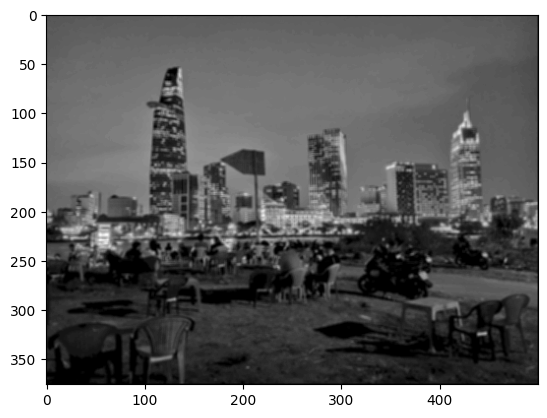

In [138]:
show(gaussianed)

### Gaussian-Opencv

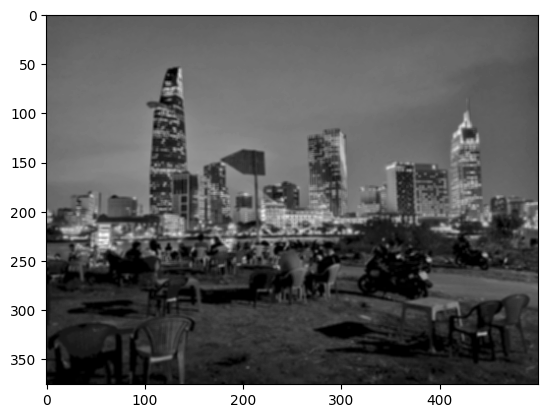

In [141]:
gaussian = cv2.GaussianBlur(gray, (3,3), sigmaX = 2,sigmaY = 2)
show(gaussian)